In [59]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools#### Comparison with vs without Land-use filter #### 
#one scenario at a time # 


models=["GBM"] 
taxas =["Mammals"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:500]

   
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            
            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        newvalue = ds["newvalue"]
                        sum_bin = ds["sum_bin"]

                        newvalue_dict[model][model_name][species_name] = newvalue
                        sum_bin_dict[model][model_name][species_name] = sum_bin

                projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model in models:
                    for model_name in model_names:
                        value_bin = newvalue_dict[model][model_name][species_name]
                        value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin


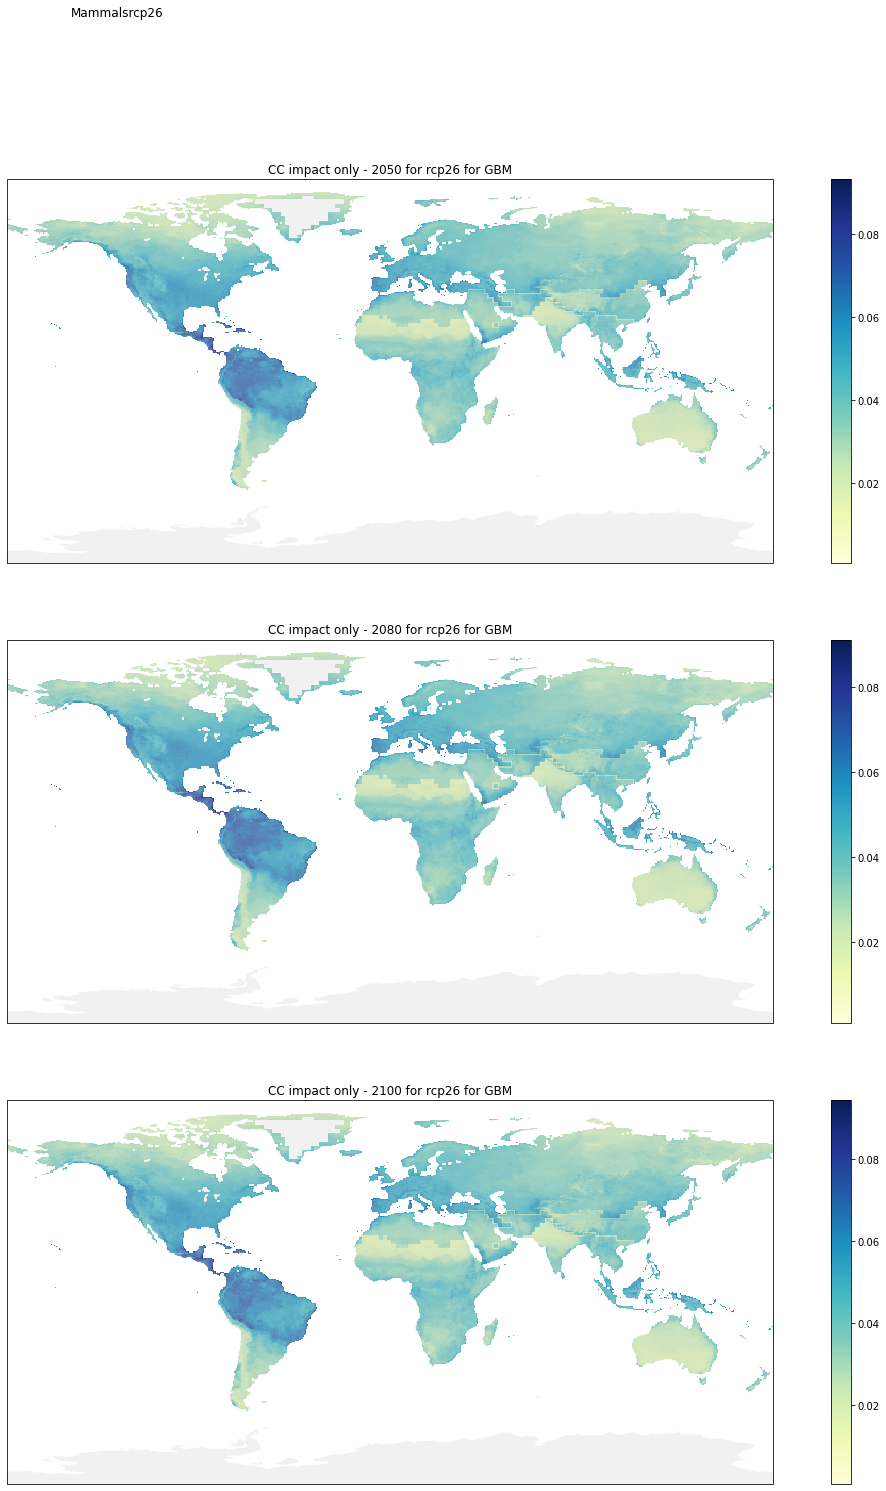

In [60]:


future_times = [35, 65, 85]
scenarios = ["rcp26"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
    for taxa in taxas:
        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]

        # Plot newvalue_bin in the left subplot
        im1 = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values > 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap="YlGnBu")
        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"CC impact only - {year_indices[future_time]} for {scenario} for GBM")
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)

          


        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + "rcp26")
        plot_idx += 1

In [11]:
def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
    sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

    for model in models:
        for model_name in model_names:
            for species_name in species_names:
                ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                newvalue = ds["newvalue"]
                sum_bin = ds["sum_bin"]
                return ds

In [20]:
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"

mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)

In [32]:
species_names='Harpiola_isodon'

In [33]:

models=["GAM","GBM"] 
taxas =["Mammals"]
time=35

model_name = 'GFDL-ESM2M'
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

ds = xr.open_dataset(netcdf_path_format_future.format(model, taxa, model_name, scenario, species_names, time), decode_times=False)
newvalue = ds["newvalue"]

In [40]:
ds

<xarray.Dataset>
Dimensions:            (time: 1, lon: 720, lat: 360, bounds: 2)
Coordinates:
  * time               (time) float64 35.0
  * lon                (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat                (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
Dimensions without coordinates: bounds
Data variables: (12/22)
    c3ann              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    c3nfx              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    c3per              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    c4ann              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    c4per              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    pastr              (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    ...                 ...
    primf_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    sum_bin            (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    difference_filter  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    secdf_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    secdn_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    primn_bin          (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes: (12/28)
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.6
    source:                  LUH2 v2.1f: Land-Use Harmonization Data Set
    institution:             University of Maryland (UofMD), College Park, MD...
    host:                    UMD College Park
    comment:                 LUH2
    ...                      ...
    source_id:               UofMD-landState-GCAM-ssp460-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/8fd188aa-2367-41e4-817b-61c41202ca38
    history:                 Sun Mar 05 15:23:55 2023: cdo remapbil,gfdl-esm4...
    NCO:                     netCDF Operators version 5.0.6 (Homepage = http:...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [39]:
newvalue.mean()

<xarray.DataArray 'newvalue' ()>
array(0.00046383)